# Multi-Criteria Decision Analysis-Based framework for supply chain management evaluation with multi-dimensional sensitivity analysis: A green logistics perspective

### Jakub Więckowski and Wojciech Sałabun

Implementations of functionalities used in the Multi-Criteria Decision Analysis process

# Imports

In [3]:
import numpy as np
import pandas as pd
import pymcdm
import pysensmcda
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Definition of helpers functions

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def correlation_heatmap(corr_matrix,
                        labels=None,
                        labels_rotation=45,
                        labeltop=False,
                        float_fmt='%0.2f',
                        cmap='Greens',
                        adapt_text_colors=None,
                        adapt_text_threshold=None,
                        colorbar=False,
                        cbar_label='',
                        show_axis=True,
                        show_grid=False,
                        grid_kwargs=dict(),
                        text_kwargs=dict(),
                        ax=None):
    """ Function for visualisation correlation matrix as a color heatmap.

        Parameters
        ----------
            corr_matrix : ndarray
                Square matrix of correlation values. For example could be generated with function pymcdm.correlation.correlation_matrix.

            labels : Iterable or None
                Labels for rankings (will be displayed as a xticklabels and yticklabels). Default is None.

            labels_rotation : float
                Angle for label rotation. In some cases labels on the X axis will be overlaps, so rotating them could help. Default is 45.

            labeltop : bool
                If True, put labels from X axis on top of the heatmap. Default is False

            float_fmt : str
                Format of the float values on the plot. Default is '%0.2f'

            cmap : str or Colormap
                Colormap for heatmap. Accepts any colormap which is valid matplotlib colormap. Default is 'Greens'.

            adapt_text_colors : tuple or None
                If None, all text will be in one color. In other case, two elements tuple should be provided. For example, passing tuple ('w', 'k') will be retulted in black text if value for this element is bigger or equal to adapt_text_threshold or 'w' if less. Default is None.

            adapt_text_threshold : float or None
                If adapt_text_colors is not None then this value is used selection of text' text. If None, then average value of corr_matrix is chosen. Default is None.

            colorbar : bool
                Add colorbar on the right side of the axis. Default is False.

            show_axis : bool
                If False, then axis (black square) around plot is disabled. Could be useful if you want to add grid to the heatmap. Default is True.

            show_grid : bool
                If True, then grid is added to the heatmap. Default is False.

            grid_kwargs : dict
                Keyword arguments to pass to the grid function.

            text_kwargs : dict
                Keyword arguments to pass to the text function (for matrix values).

            ax : Axes
                Axes object to draw on.

        Returns
        -------
            ax : Axes
                Axes object on which plot were drawn.

            cax : Axes
                Only if colorbar=True.
                Axes object on which colorbar were drawn.
    """
    corr_matrix = np.asarray(corr_matrix)

    if ax is None:
        ax = plt.gca()

    if labels is None:
        labels = [f'$R_{{{i + 1}}}$' for i in range(corr_matrix.shape[0])]

    im = ax.imshow(corr_matrix, cmap=cmap)

    text_kwargs = dict(
        ha='center',
        va='center',
        color='k'
    ) | text_kwargs

    if adapt_text_colors is not None:
        if adapt_text_threshold is None:
            adapt_text_threshold = np.mean(corr_matrix)

        for i in range(len(labels)):
            for j in range(len(labels)):
                text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]
                text = ax.text(j, i, float_fmt % corr_matrix[i, j], **text_kwargs)
    else:
        for i in range(len(labels)):
            for j in range(len(labels)):
                text = ax.text(j, i, float_fmt % corr_matrix[i, j], **text_kwargs)

    if labeltop:
        ax.tick_params(top=labeltop, bottom=not labeltop,
                       labeltop=labeltop, labelbottom=not labeltop)

    if not show_axis:
        ax.spines[:].set_visible(False)

    if labels_rotation:
        plt.setp(ax.get_xticklabels(), rotation=labels_rotation,
                 ha='left' if labeltop else 'right', rotation_mode='anchor')

    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    if show_grid:
        grid_kwargs = dict(
            color='w',
            linestyle='-',
            linewidth=3
        ) | grid_kwargs | dict(which='minor')

        ax.set_xticks(np.arange(corr_matrix.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(corr_matrix.shape[0]+1)-.5, minor=True)
        ax.grid(**grid_kwargs)
        ax.tick_params(which='minor', bottom=False, left=False)

    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label(cbar_label, fontsize=12)
        return ax, cax

    return ax

def polar_weights(weights,
                  xticklabels=None,
                  bar_kwargs=dict(),
                  legend_ncol=5,
                  colors=None,
                  ax=None):
    """ Function for criteria weights visualisation.

        Parameters
        ----------
            weights : ndarray
                Matrix of weights. Each row is a vector of weights.

            xticklabels : None or Iterable
                Labels for bars (names for the different weighting methods).

            bar_kwargs : dict
                Keywors arguments to pass into bar function.

            legend_ncol : int
                Number of columns in legend.

            colors : Iterable or None
                Colors for bars. If there are less colors then criteria, then colors will be cycled.
            ax : Axes or None
                Axes object to dwaw on.

        Returns
        -------
            ax : Axes
                Axes object on which plot were drawn.

        Examples
        --------
            >>> import numpy as np
            >>> import matplotlib.pyplot as plt
            >>> from pymcdm.visuals import polar_weights
            >>> w = np.array([[0.3, 0.2, 0.5],
            ...              [0.2, 0.5, 0.3]])
            >>> polar_weights(w)
            >>> plt.show()
    """

    weights = np.array(weights).T

    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    if xticklabels is None:
        xticklabels = [f'$C_{{{i + 1}}}$' for i in range(weights.shape[0])]

    theta = np.linspace(0.0, 2 * np.pi, weights.shape[0], endpoint=False)

    width = 2 * np.pi / weights.shape[0] 

    bar_kwargs = dict(
        linewidth=1,
        edgecolor='black',
        alpha=0.6
    ) | bar_kwargs

    for i, alt in enumerate(weights):
        if colors is not None:
            bar_kwargs['color'] = colors[i % len(colors)]

        if i == 0:
            ax.bar(theta, alt, width=width, label=f'$P_{i + 1}$', **bar_kwargs)
        else:
            ax.bar(theta, alt, width=width, label=f'$P_{i + 1}$', bottom=np.sum(weights[:i], axis=0), **bar_kwargs)

    ax.grid(True, alpha=0.7, linestyle='--')
    ax.set_axisbelow(True)

    ax.set_xticks(theta)
    ax.set_xticklabels(xticklabels, fontsize=14)

    ax.set_ylim([0, 1.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)

    ax.legend(bbox_to_anchor=(0., 1.1, 1., .11), loc='lower left',
              ncol=legend_ncol, mode="expand", borderaxespad=0., fontsize=14)

    return ax



## Definition of methods used in the evaluation

### Ranking Comparison (RANCOM)

```
Więckowski, J., Kizielewicz, B., Shekhovtsov, A., & Sałabun, W. (2023). RANCOM: A novel approach to identifying criteria relevance based on inaccuracy expert judgments. Engineering Applications of Artificial Intelligence, 122, 106114.
```

In [5]:
def RANCOM(ranking, verbose=False):
    """Calculate criteria weights based on the given numerical hierarchy. Lower value means higher relevance.

    Parameters
    ----------
        ranking : ndarray
            Numerical values for criteria relevance (lower - more relevant).

        verbose : bool
            Flag for showing partial results of the RANCOM method
    Returns
    -------
        ndarray
            Criteria weights in range 0-1.
    """
    def f(c1, c2):
        if c1 < c2:
            return 1
        if c1 == c2:
            return 0.5
        return 0

    def build_mac(ranking):
        co = np.array(list(ranking))

        mac = np.diag(np.ones(co.shape[0]) * 0.5)
        for i in range(mac.shape[0]):
            for j in range(i+1, mac.shape[1]):
                v = f(co[i], co[j])
                mac[i, j] = v
                mac[j, i] = 1 - v
        return mac

    def get_weights(ranking):
        mac = build_mac(ranking)
        scw = np.sum(mac, axis=1)
        p = scw / np.sum(scw)

        if verbose:
            print('------- MAC ---------')
            print(mac)
            print('------- SCW ---------')
            print(scw)
            print('------- WEIGHTS ---------')
            print(p)

        return p

    return get_weights(ranking)
    

### Comprehensive Analysis Method (COMSAM)

```
Więckowski, J., & Sałabun, W. (2024). A new sensitivity analysis method for decision-making with multiple parameters modification. Information Sciences, 120902.
```

In [6]:
import itertools

def generate_criteria_index_sets(matrix, min_crit=3):
    S = []
    # generate vector of criteria indexes
    criteria_set = np.arange(0, matrix.shape[1], 1)
    # generate sets of criteria indexes (S)
    for i in range(min_crit, matrix.shape[1]+1):
        S.extend(list(itertools.combinations(criteria_set, i)))
    return S

def generate_modifications_sets(B, S, step=1):
    M, modification_steps = [], []
    # for each modification bound (B) generate vector of modification sizes
    for b in B:
        modification_steps.append(np.arange(0, b+1))
    # for each set of criteria indexes (S) generate a cartesian product of modification sizes (M)
    for index_set in S:
        M.append(list(itertools.product(*[modification_steps[i] for i in index_set])))
    return M

def get_interval_prefs(mcda_method, matrix, weights, criteria_types, bounds, step=1):
    S = generate_criteria_index_sets(matrix)
    M = generate_modifications_sets(bounds, S, step)
    
    interval_pref = []
    # examine each alternative
    for i in tqdm(range(matrix.shape[0])):
        alt_pref = []
        # modify matrix for each criteria index set and modifications
        for crit_indexes, modification_set in zip(S, M):
            for single_modification in modification_set:
                # copy initial matrix
                npmatrix = matrix.copy()
                nmmatrix = matrix.copy()

                # modify matrix for criteria indexes by increasing and decreasing
                for j, mod_val in zip(crit_indexes, single_modification):
                    npmatrix[i, j] = matrix[i, j] + matrix[i, j] * (mod_val/100)
                    nmmatrix[i, j] = matrix[i, j] - matrix[i, j] * (mod_val/100)

                # assess matrices after changes
                nppref = mcda_method(npmatrix, weights, criteria_types)
                nmpref = mcda_method(nmmatrix, weights, criteria_types)

                # save preferences of alternatives
                alt_pref.extend([nppref[i], nmpref[i]])

        interval_pref.append(alt_pref)
    
    return interval_pref

### Dataset used in the evaluation

https://www.kaggle.com/datasets/lastman0800/supply-chain-management

In [7]:
data = pd.read_excel('data/SCM_Dataset_Updated_with_Green_Logistics.xlsx')
data

,Company Name,SCM Practices,Supplier Count,Inventory Turnover Ratio,Lead Time (days),Order Fulfillment Rate (%),Customer Satisfaction (%),Technology Utilized,Environmental Impact Score,Supply Chain Agility,...,Supply Chain Risk (%),Supplier Collaboration Level,Supply Chain Resilience Score,Supplier Relationship Score,Total Implementation Cost,Carbon Emissions (kg CO2e),Recycling Rate (%),Energy Consumption (MWh),Use of Renewable Energy (%),Green Packaging Usage (%)
0,Apple,Agile SCM,300.0,7.0,8.0,94.0,91.0,"ERP, AI, Blockchain",70.0,High,...,7.0,High,90.0,85.0,48566365,120000,60,100000,50,40
1,Microsoft,Lean Manufacturing,200.0,5.2,15.0,91.0,89.0,"ERP, AI, Robotics",75.0,High,...,12.0,Medium,85.0,85.0,54456148,121000,61,100500,51,41
2,Google,Cross-Docking,20000.0,7.5,4.0,95.0,90.0,"AI, ERP, Blockchain",70.0,High,...,5.0,High,90.0,85.0,78733131,122000,62,101000,52,42
3,Amazon,Agile SCM,500.0,10.5,15.0,95.0,90.0,"ERP, AI, Blockchain",70.0,High,...,12.0,Medium,88.0,85.0,1635157,123000,63,101500,53,43
4,Facebook,Lean Manufacturing,100.0,5.8,12.0,89.0,88.0,"ERP, AI, Robotics",75.0,High,...,10.0,Medium,85.0,80.0,73150360,124000,64,102000,54,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"Nisshin Steel Co., Ltd.",Lean Manufacturing,20000.0,8.2,15.0,91.0,90.0,"ERP, AI, Blockchain",NaN,Medium,...,10.0,Medium,85.0,80.0,11471762,1115000,65,597500,53,48
996,NSSMC,Lean Manufacturing,150.0,5.2,12.0,91.0,88.0,"ERP, AI, Blockchain",NaN,High,...,10.0,High,88.0,85.0,100846359,1116000,66,598000,54,49
997,Vallourec & Mannesmann Tubes,Vendor Managed Inventory,1300000.0,7.0,10.0,90.0,89.0,"ERP, AI, Blockchain",NaN,High,...,8.0,High,87.0,85.0,16816570,1117000,67,598500,55,50
998,Tubacex,Agile SCM,200.0,5.5,12.0,88.0,92.0,"AI, ERP, Blockchain",NaN,Medium,...,15.0,Medium,80.0,78.0,25856920,1118000,68,599000,56,51


In [8]:
data.columns

Index(['Company Name', 'SCM Practices', 'Supplier Count',
       'Inventory Turnover Ratio', 'Lead Time (days)',
       'Order Fulfillment Rate (%)', 'Customer Satisfaction (%)',
       'Technology Utilized', 'Environmental Impact Score',
       'Supply Chain Agility', 'Supplier Lead Time Variability (days)',
       'Inventory Accuracy (%)', 'Transportation Cost Efficiency (%)',
       'Supply Chain Integration Level', 'Sustainability Practices',
       'Supply Chain Complexity Index', 'Cost of Goods Sold (COGS)',
       'Operational Efficiency Score', 'Revenue Growth Rate out of (15)',
       'Supply Chain Risk (%)', 'Supplier Collaboration Level',
       'Supply Chain Resilience Score', 'Supplier Relationship Score',
       'Total Implementation Cost', 'Carbon Emissions (kg CO2e)',
       'Recycling Rate (%)', 'Energy Consumption (MWh)',
       'Use of Renewable Energy (%)', 'Green Packaging Usage (%)'],
      dtype='object')

In [9]:
data['SCM Practices'].unique()

array(['Agile SCM', 'Lean Manufacturing', 'Cross-Docking',
       'Sustainable SCM', 'Demand-Driven SCM', 'Vendor Managed Inventory',
       'Efficient Consumer Response', 'Just-In-Time', nan], dtype=object)

In [10]:
data.groupby(by=['SCM Practices']).count()

,Company Name,Supplier Count,Inventory Turnover Ratio,Lead Time (days),Order Fulfillment Rate (%),Customer Satisfaction (%),Technology Utilized,Environmental Impact Score,Supply Chain Agility,Supplier Lead Time Variability (days),...,Supply Chain Risk (%),Supplier Collaboration Level,Supply Chain Resilience Score,Supplier Relationship Score,Total Implementation Cost,Carbon Emissions (kg CO2e),Recycling Rate (%),Energy Consumption (MWh),Use of Renewable Energy (%),Green Packaging Usage (%)
SCM Practices,,,,,,,,,,,,,,,,,,,,,
Agile SCM,312,312,312,312,312,312,312,28,312,312,...,312,312,312,312,312,312,312,312,312,312
Cross-Docking,18,18,18,18,18,18,18,2,18,18,...,18,18,18,18,18,18,18,18,18,18
Demand-Driven SCM,57,57,57,57,57,57,57,5,57,57,...,57,57,57,57,57,57,57,57,57,57
Efficient Consumer Response,12,12,12,12,12,12,12,1,12,12,...,12,12,12,12,12,12,12,12,12,12
Just-In-Time,34,34,34,34,34,34,34,3,34,34,...,34,34,34,34,34,34,34,34,34,34
Lean Manufacturing,326,326,326,326,326,326,326,29,326,326,...,326,326,326,326,326,326,326,326,326,326
Sustainable SCM,69,69,69,69,69,69,69,6,69,69,...,69,69,69,69,69,69,69,69,69,69
Vendor Managed Inventory,171,171,171,171,171,171,171,15,171,171,...,171,171,171,171,171,171,171,171,171,171


Data filtering to check what shapes of dataframes for selected `SCM Practices`

In [11]:
data = data[data['SCM Practices'] == 'Cross-Docking']
# data = data[data['SCM Practices'] == 'Efficient Consumer Response']
# data = data[data['SCM Practices'] == 'Just-In-Time']
# data = data[data['SCM Practices'] == 'Agile SCM']

Criteria and their assignment to submodels in the defined model structure

In [12]:
operational_criteria = [
    'Inventory Turnover Ratio', 
    'Lead Time (days)', 
    'Order Fulfillment Rate (%)',
    'Supplier Lead Time Variability (days)',
    'Inventory Accuracy (%)'
]

environmental_criteria = [
    'Carbon Emissions (kg CO2e)',
    'Recycling Rate (%)', 
    'Energy Consumption (MWh)',
    'Use of Renewable Energy (%)',
    'Green Packaging Usage (%)'
]

performance_customer_satisfaction_criteria = [
    'Transportation Cost Efficiency (%)',
    'Customer Satisfaction (%)',
    'Supplier Relationship Score'
]

risk_resilience_criteria = [
    'Supply Chain Risk (%)', 
    'Supply Chain Resilience Score', 
    'Total Implementation Cost'
]

criteria_columns = [*operational_criteria, *environmental_criteria, *performance_customer_satisfaction_criteria, *risk_resilience_criteria]

data = data[['Company Name', *criteria_columns]].dropna()
data

,Company Name,Inventory Turnover Ratio,Lead Time (days),Order Fulfillment Rate (%),Supplier Lead Time Variability (days),Inventory Accuracy (%),Carbon Emissions (kg CO2e),Recycling Rate (%),Energy Consumption (MWh),Use of Renewable Energy (%),Green Packaging Usage (%),Transportation Cost Efficiency (%),Customer Satisfaction (%),Supplier Relationship Score,Supply Chain Risk (%),Supply Chain Resilience Score,Total Implementation Cost
2,Google,7.5,4.0,95.0,1.0,98.0,122000,62,101000,52,42,88.0,90.0,85.0,5.0,90.0,78733131
74,Domo,8.3,2.0,98.0,1.0,98.0,194000,68,137000,60,51,90.0,90.0,85.0,5.0,90.0,90354784
91,H2O.ai,7.0,4.0,95.0,1.0,98.0,211000,63,145500,61,47,88.0,90.0,85.0,5.0,90.0,72807713
163,NextGen Healthcare,7.5,2.0,98.0,1.0,98.0,283000,69,181500,53,56,90.0,90.0,85.0,5.0,90.0,94555919
248,BAIC Group,10.0,10.0,92.0,4.0,98.0,368000,66,224000,58,57,85.0,92.0,85.0,8.0,89.0,15734210
265,Damon Motorcycles,6.2,10.0,93.0,2.0,98.0,385000,61,232500,59,53,88.0,89.0,85.0,8.0,90.0,44054179
337,Triangle Tire,10.0,10.0,92.0,4.0,98.0,457000,67,268500,51,41,85.0,94.0,85.0,8.0,89.0,46626915
422,Mr. Tire Auto Service Centers,5.2,9.0,92.0,3.0,99.0,542000,64,311000,56,42,88.0,90.0,85.0,8.0,88.0,60779109
439,Sears Auto Center,6.5,22.0,89.0,5.0,96.0,559000,70,319500,57,59,85.0,92.0,80.0,15.0,85.0,84504548
511,Belle Tire,5.8,9.0,92.0,3.0,99.0,631000,65,355500,65,47,88.0,90.0,85.0,8.0,88.0,88720438


Decision matrix and criteria types definition

In [13]:
matrix = data.drop(columns=['Company Name']).to_numpy()
criteria_types = np.array([1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1])

Definition of submodels structure with ranking of criteria within submodels, indexes of criteria, and modification bounds for COMSAM method

In [14]:
models = [
    {'name': "$P_{{1}}$", 'criteria': operational_criteria, 'indexes': [0, 5], 'weights': [3, 1, 5, 4, 2], 'bounds': [10, 10, 10, 10, 10]},
    {'name': "$P_{{2}}$", 'criteria': environmental_criteria, 'indexes': [5, 10], 'weights': [2, 4, 1, 5, 3], 'bounds': [10, 10, 10, 10, 10]},
    {'name': "$P_{{3}}$", 'criteria': performance_customer_satisfaction_criteria, 'indexes': [10, 13], 'weights': [2, 1, 3], 'bounds': [10, 10, 10]},
    {'name': "$P_{{4}}$", 'criteria': risk_resilience_criteria, 'indexes': [13, 16], 'weights': [3, 1, 2], 'bounds': [10, 10, 10]},
]


Ranking of submodels regarding different objectives

In [15]:
environmental_rank_model = [2, 1, 4, 3]
performance_rank_model = [1, 4, 3, 2]
customer_rank_model = [3, 2, 1, 4]
risk_rank_model = [3, 2, 4, 1]

Model weights calculation regarding different objectives

In [16]:
environmental_weights_model = RANCOM(environmental_rank_model)
performance_weights_model = RANCOM(performance_rank_model)
customer_weights_model = RANCOM(customer_rank_model)
risk_weights_model = RANCOM(risk_rank_model)
print('Environmental weights')
print(environmental_weights_model)
print('Performance weights')
print(performance_weights_model)
print('Customer weights')
print(customer_weights_model)
print('Risk weights')
print(risk_weights_model)

Environmental weights
[0.3125 0.4375 0.0625 0.1875]
Performance weights
[0.4375 0.0625 0.1875 0.3125]
Customer weights
[0.1875 0.3125 0.4375 0.0625]
Risk weights
[0.1875 0.3125 0.0625 0.4375]


Calculation of weights and rankings for submodels

In [17]:
base_weights = []
base_prefs, base_ranks = [], []

for model in models:
    print(f"Submodel: {model['name']}")
    model_criteria_types = criteria_types[model['indexes'][0]:model['indexes'][1]]
    model_matrix = data[model['criteria']].to_numpy()
    rank_weights = np.array(model['weights'])

    model_weights = RANCOM(rank_weights)
    print(f'Weights: {model_weights}')

    base_weights.append(model_weights)

    marcos = pymcdm.methods.MARCOS()
    prefs = marcos(model_matrix, model_weights, model_criteria_types)
    ranks = marcos.rank(prefs)
    
    print(f'Preferences: {prefs}')
    print(f'Ranking: {ranks}')
    print('')

    base_prefs.append(prefs)
    base_ranks.append(ranks)

Submodel: $P_{{1}}$
Weights: [0.2  0.36 0.04 0.12 0.28]
Preferences: [0.5846163  0.75153019 0.58280619 0.74863402 0.41335816 0.42712235
 0.41335816 0.41483184 0.3534855  0.41700397 0.41915788 0.44124856
 0.58568759 0.38689763 0.427839   0.38762168 0.3807285  0.43399336]
Ranking: [ 4.   1.   5.   2.  13.5  9.  13.5 12.  18.  11.  10.   6.   3.  16.
  8.  15.  17.   7. ]

Submodel: $P_{{2}}$
Weights: [0.28 0.12 0.36 0.04 0.2 ]
Preferences: [0.83679628 0.69709362 0.65063702 0.6001599  0.54127217 0.51272923
 0.44931983 0.4229289  0.47991968 0.42328901 0.39966257 0.3946971
 0.40828072 0.39020869 0.38616006 0.40308443 0.40526123 0.38455283]
Ranking: [ 1.  2.  3.  4.  5.  6.  8. 10.  7.  9. 14. 15. 11. 16. 17. 13. 12. 18.]

Submodel: $P_{{3}}$
Weights: [0.33333333 0.55555556 0.11111111]
Preferences: [0.67189784 0.67703434 0.67189784 0.67703434 0.67238963 0.66779957
 0.68058617 0.67189784 0.66785742 0.67189784 0.66779957 0.65140648
 0.67599611 0.6764879  0.66473952 0.67238963 0.67195569 0.6729

Calculation of final rankings based on the preference scores from four submodels

In [18]:
final_matrix = np.array(base_prefs).T
final_criteria_types = np.array([1, 1, 1, 1])
base_final_prefs = marcos(final_matrix, environmental_weights_model, final_criteria_types)
base_final_ranks = marcos.rank(base_final_prefs)

print(base_final_prefs)
print(base_final_ranks)

[0.74167701 0.73880952 0.65843091 0.69465948 0.54754858 0.53589591
 0.5027049  0.48926122 0.48368154 0.48961982 0.48209104 0.54151974
 0.54576271 0.46223215 0.47928017 0.46803247 0.47078072 0.48146909]
[ 1.  2.  4.  3.  5.  8.  9. 11. 12. 10. 13.  7.  6. 18. 15. 17. 16. 14.]


Comparison with monolith structure

In [19]:
monolith_weights = []
for idx, base_w in enumerate(base_weights):
    monolith_weights.extend([w * environmental_weights_model[idx] for w in base_w])

monolith_weights = np.array(monolith_weights)
monolith_weights = monolith_weights / np.sum(monolith_weights)

print('Monolith structure weights')
print(monolith_weights, np.sum(monolith_weights))

monolith_prefs = marcos(matrix, monolith_weights, criteria_types)
monolith_ranks = marcos.rank(monolith_prefs)

print('Preference scores')
print(monolith_prefs)
print('Ranking')
print(monolith_ranks)

Monolith structure weights
[0.0625     0.1125     0.0125     0.0375     0.0875     0.1225
 0.0525     0.1575     0.0175     0.0875     0.02083333 0.03472222
 0.00694444 0.02083333 0.10416667 0.0625    ] 1.0
Preference scores
[0.69553548 0.68744962 0.6163697  0.64552076 0.51618575 0.50447066
 0.47333758 0.46037983 0.45661917 0.46062531 0.45348445 0.51175567
 0.50877914 0.43544267 0.45053039 0.44092534 0.44395399 0.45246142]
Ranking
[ 1.  2.  4.  3.  5.  8.  9. 11. 12. 10. 13.  6.  7. 18. 15. 17. 16. 14.]


### MCDA methods comparison

In [20]:
methods_dict = {
    'ARAS': pymcdm.methods.ARAS(),
    'CODAS': pymcdm.methods.CODAS(),
    'COPRAS': pymcdm.methods.COPRAS(),
    'PROBID': pymcdm.methods.PROBID(),
    'TOPSIS': pymcdm.methods.TOPSIS()
}

mcda_ranks = [base_final_ranks]

for name, method in methods_dict.items():
    print(name)
    mcda_monolith_prefs = method(matrix, monolith_weights, criteria_types)
    mcda_monolith_ranks = method.rank(mcda_monolith_prefs)
    print(f'Ranking: {mcda_monolith_ranks}')
    mcda_ranks.append(mcda_monolith_ranks)


ARAS
Ranking: [ 1.  2.  4.  3.  7.  8.  9. 10. 12. 11. 13.  5.  6. 18. 15. 17. 14. 16.]
CODAS
Ranking: [ 1.  2.  4.  3.  7.  8.  9. 11. 10. 12. 15.  5.  6. 18. 16. 17. 14. 13.]
COPRAS
Ranking: [ 1.  2.  3.  4.  6.  7.  8. 10. 14. 11. 12.  9.  5. 18. 13. 17. 16. 15.]
PROBID
Ranking: [ 1.  3.  2.  4.  5.  6.  7.  9. 12. 11. 13. 10.  8. 17. 15. 18. 14. 16.]
TOPSIS
Ranking: [ 4.  1.  3.  2.  5.  6.  7.  8. 15. 10. 12. 11.  9. 18. 13. 16. 17. 14.]


Calculation of the correlation values between rankings with Spearman weighted correlation coefficient (rw) and Weighted Similarity rank coefficient (WS)

In [21]:
corr_rw = [[pymcdm.correlations.rw(r1, r2) for r2 in mcda_ranks]for r1 in mcda_ranks]
corr_ws = [[pymcdm.correlations.ws(r1, r2) for r2 in mcda_ranks]for r1 in mcda_ranks]

Rw heatmap generation

C:\Users\kubaw\AppData\Local\Temp\ipykernel_47500\1860385454.py:95: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]


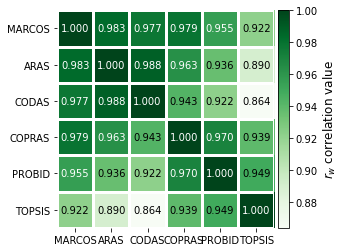

In [22]:
labels = ['MARCOS', *list(methods_dict.keys())]

plt.rcParams['figure.figsize'] = (6, 6)
correlation_heatmap(np.array(corr_rw), labels, labels_rotation=0, float_fmt='%0.3f', cmap='Greens', adapt_text_colors=['k', 'w'], colorbar=True, show_axis=False, show_grid=True, cbar_label='$r_w$ correlation value')
plt.savefig('img/rw_corr_mcda.pdf')
plt.show()

WS heatmap generation

C:\Users\kubaw\AppData\Local\Temp\ipykernel_47500\1860385454.py:95: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]


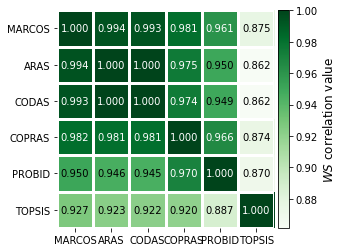

In [23]:
correlation_heatmap(np.array(corr_ws), labels, labels_rotation=0, float_fmt='%0.3f', cmap='Greens', adapt_text_colors=['k', 'w'], colorbar=True, show_axis=False, show_grid=True, cbar_label='$WS$ correlation value')
plt.savefig('img/ws_corr_mcda.pdf')
plt.show()

### Different target oriented evaluation

Submodels analysis

In [24]:
target_data = [environmental_weights_model, performance_weights_model, customer_weights_model, risk_weights_model]
target_labels = ['Environmental', 'Performance', 'Customer', 'Risk']

target_weights = []
target_prefs, target_ranks = [], []

for t_data in target_data:
    temp_weights = []
    temp_prefs, temp_ranks = [], []
    for model in models:
        model_criteria_types = criteria_types[model['indexes'][0]:model['indexes'][1]]
        model_matrix = data[model['criteria']].to_numpy()
        rank_weights = np.array(model['weights'])

        model_weights = RANCOM(rank_weights)

        temp_weights.append(model_weights)

        marcos = pymcdm.methods.MARCOS()
        prefs = marcos(model_matrix, model_weights, model_criteria_types)
        ranks = marcos.rank(prefs)
    
        temp_prefs.append(prefs)
        temp_ranks.append(ranks)

    target_weights.append(temp_weights)
    target_prefs.append(temp_prefs)
    target_ranks.append(temp_ranks)

Final model evaluation

In [25]:
targeted_final_ranks = []

for idx, t_data in enumerate(target_prefs):
    print(f'Objective: {target_labels[idx]}')
    performance_matrix = np.array(t_data).T
    performance_criteria_types = np.array([1, 1, 1, 1])
    prefs = marcos(performance_matrix, target_data[idx], performance_criteria_types)
    ranks = marcos.rank(prefs)

    print(f'Preference scores: {np.round(prefs, 3)}')
    print(f'Ranking: {ranks}')
    print('')

    targeted_final_ranks.append(ranks)

Objective: Environmental
Preference scores: [0.742 0.739 0.658 0.695 0.548 0.536 0.503 0.489 0.484 0.49  0.482 0.542
 0.546 0.462 0.479 0.468 0.471 0.481]
Ranking: [ 1.  2.  4.  3.  5.  8.  9. 11. 12. 10. 13.  7.  6. 18. 15. 17. 16. 14.]

Objective: Performance
Preference scores: [0.658 0.73  0.646 0.723 0.555 0.553 0.544 0.539 0.498 0.539 0.541 0.636
 0.624 0.52  0.545 0.52  0.524 0.549]
Ranking: [ 3.  1.  4.  2.  7.  8. 11. 14. 18. 13. 12.  5.  6. 17. 10. 16. 15.  9.]

Objective: Customer
Preference scores: [0.73  0.724 0.675 0.695 0.609 0.6   0.585 0.573 0.573 0.573 0.566 0.577
 0.605 0.559 0.562 0.561 0.562 0.567]
Ranking: [ 1.  2.  4.  3.  5.  7.  8. 11. 12. 10. 14.  9.  6. 18. 15. 17. 16. 13.]

Objective: Risk
Preference scores: [0.69  0.681 0.632 0.65  0.557 0.542 0.518 0.506 0.49  0.505 0.504 0.632
 0.543 0.483 0.502 0.487 0.496 0.503]
Ranking: [ 1.  2.  5.  3.  6.  8.  9. 10. 16. 11. 12.  4.  7. 18. 14. 17. 15. 13.]



Generation of weights distribution for examined scenarios

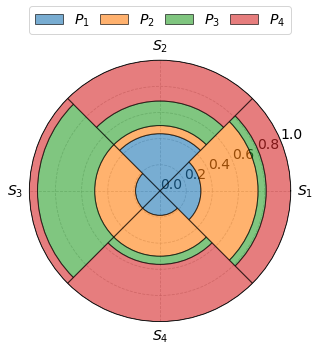

In [26]:
plt.rcParams['figure.figsize'] = (5, 5)
polar_weights(np.array(target_data),['$S_1$', '$S_2$', '$S_3$', '$S_4$'])
plt.tight_layout()
plt.savefig('img/weights_polar.pdf')
plt.show()

### COMSAM method application

Calculation about 20 minutes for 10% changes

In [29]:
for model in models:
    model_criteria_types = criteria_types[model['indexes'][0]:model['indexes'][1]]
    model_matrix = data[model['criteria']].to_numpy()
    rank_weights = model['weights']
    model_weights = RANCOM(rank_weights)

    print(model['name'])
    results = get_interval_prefs(marcos, model_matrix, model_weights, model_criteria_types, model['bounds'])
    model['results'] = results

100%|██████████| 18/18 [11:14<00:00, 37.50s/it]


$P_{{1}}$


100%|██████████| 18/18 [08:45<00:00, 29.17s/it]


$P_{{2}}$


100%|██████████| 18/18 [00:02<00:00,  7.96it/s]


$P_{{3}}$


100%|██████████| 18/18 [00:02<00:00,  7.39it/s]

$P_{{4}}$


Visualization of distribution for preference scores for single submodel for each alternative

In [100]:
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['axes.axisbelow'] = True

colors=['blue', 'red','green', 'orange']

all_prefs_models = []

for m in models:
    for results in m['results']:
        all_prefs_models.extend(results)

min_val = np.min(all_prefs_models) - 0.05
max_val = np.max(all_prefs_models) + 0.05

for m_idx, m in enumerate(models):

    for idx, results in enumerate(m['results']):    
        sns.kdeplot(results, color=colors[m_idx], fill=True, alpha=0.4)
        plt.ylabel('Density', fontsize=14)
        plt.xlabel('Preference score', fontsize=14)
        plt.title(f'Model $P_{m_idx+1}$ Alternative $A_{{{idx+1}}}$', fontsize=14)

        plt.xlim([min_val, max_val])
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        ax = plt.gca()
        plt.tight_layout()
        plt.savefig(f'img/comsam_p{m_idx+1}_a{idx+1}.pdf')
        plt.close()
        plt.show()



Visualization of distribution for preference scores for examined submodels together in one plot for each alternative

In [102]:
plt.rcParams['figure.figsize'] = (8, 4)

for i in range(18):
    colors=['blue', 'red','green', 'orange']
    for idx, m in enumerate(models):
        results = m['results'][i]
        sns.kdeplot(results, color=colors[idx], fill=True, alpha=0.4, label=f'Model $P_{{{idx+1}}}$')
    plt.ylabel('Density', fontsize=16)
    plt.xlabel(f'Preference score $A_{{{i+1}}}$', fontsize=14)


    plt.xlim([min_val, max_val])
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    ax = plt.gca()
    plt.savefig(f'img/comsam_a{i+1}.pdf')
    plt.close()
    plt.show()


### Submodels exclusion

In [27]:
excluded_prefs = []
excluded_ranks = []

excluded_rw = []
excluded_ws = []

pref_diff = []

for i in range(len(base_prefs)):
    print(f'Excluded submodel: {i+1}')
    final_matrix = np.array(base_prefs).T
    final_matrix = np.delete(final_matrix, i, axis=1)

    final_criteria_types = np.array([1, 1, 1])
    excluded_model_weights = environmental_weights_model.copy()
    excluded_model_weights = np.delete(excluded_model_weights, i, axis=0)
    excluded_model_weights = excluded_model_weights / np.sum(excluded_model_weights)
    
    excluded_final_prefs = marcos(final_matrix, excluded_model_weights, final_criteria_types)
    excluded_final_ranks = marcos.rank(excluded_final_prefs)

    print(f'Preference scores: {excluded_final_prefs}')
    print(f'Ranking: {excluded_final_ranks}')
    print('')
    
    excluded_prefs.append(excluded_final_prefs)
    excluded_ranks.append(excluded_final_ranks)

    pref_diff.append(np.sum(np.abs(base_final_prefs-excluded_final_prefs)))
    excluded_rw.append(pymcdm.correlations.rw(base_final_ranks, excluded_final_ranks))
    excluded_ws.append(pymcdm.correlations.ws(base_final_ranks, excluded_final_ranks))


Excluded submodel: 1
Preference scores: [0.77022269 0.6811833  0.65131277 0.6191037  0.5779012  0.5541254
 0.5133498  0.49324826 0.51642429 0.49265947 0.48072624 0.55503455
 0.48766381 0.46855114 0.47226384 0.47653222 0.48399493 0.47228391]
Ranking: [ 1.  2.  3.  4.  5.  7.  9. 10.  8. 11. 14.  6. 12. 18. 17. 15. 13. 16.]

Excluded submodel: 2
Preference scores: [0.64319573 0.74616619 0.64228066 0.7442923  0.53395971 0.53575165
 0.52703008 0.5240443  0.47030027 0.52438966 0.52955412 0.63674306
 0.63362503 0.50232336 0.53510003 0.50246071 0.50555801 0.54014876]
Ranking: [ 3.  1.  4.  2. 10.  8. 12. 14. 18. 13. 11.  5.  6. 17.  9. 16. 15.  7.]

Excluded submodel: 3
Preference scores: [0.74553009 0.74199476 0.65548484 0.69423875 0.53550464 0.52328773
 0.48630635 0.47249815 0.46680385 0.47288604 0.46508834 0.53075485
 0.53326844 0.44287396 0.46230622 0.44949401 0.45250336 0.46398194]
Ranking: [ 1.  2.  4.  3.  5.  8.  9. 11. 12. 10. 13.  7.  6. 18. 15. 17. 16. 14.]

Excluded submodel: 4
Pr

Statistics from the evaluation

* Difference in preference scores
* rw correlation
* WS correlation

In [28]:
print(np.round(pref_diff, 3))
print(np.round(excluded_rw, 3))
print(np.round(excluded_ws, 3))

[0.385 0.747 0.233 0.312]
[0.928 0.838 1.    0.96 ]
[0.978 0.902 1.    0.992]


Visualization of ranking flows

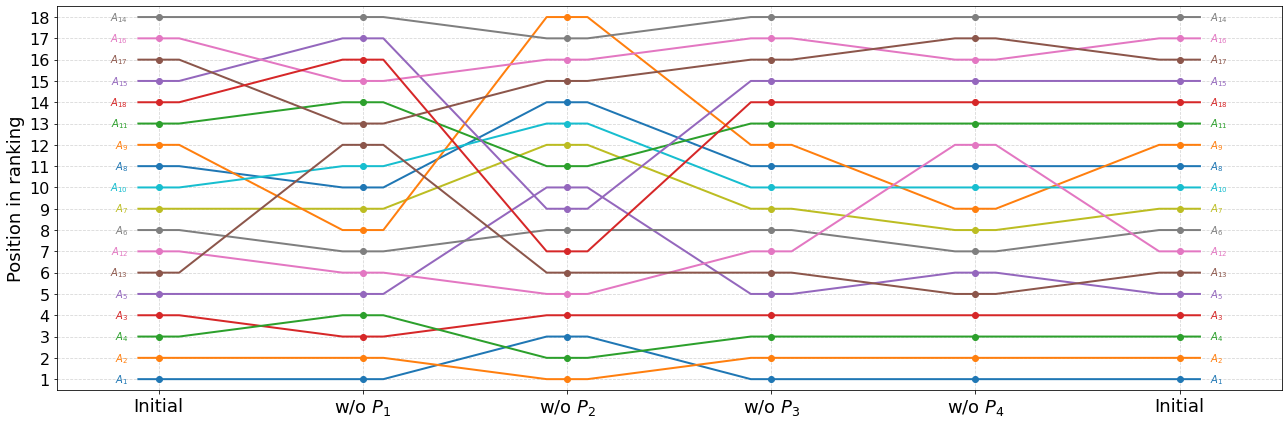

In [29]:
labels = ['Initial', 'w/o $P_{{1}}$','w/o $P_{{2}}$','w/o $P_{{3}}$','w/o $P_{{4}}$', 'Initial']
excluded_comparison_ranks = [base_final_ranks, *excluded_ranks, base_final_ranks]

plt.rcParams['figure.figsize'] = (18, 6)
pymcdm.visuals.ranking_flows(np.array(excluded_comparison_ranks), labels)
plt.xticks(np.arange(len(labels)), labels, fontsize=18)
plt.ylabel('Position in ranking', fontsize=18)
plt.yticks(np.arange(1, 19), np.arange(1, 19), fontsize=16)

plt.tight_layout()
plt.savefig('img/excluded_models_comparison.pdf')
plt.show()
